In [73]:

#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import xraydb
import plotly
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
# import pyxray as xy
import seaborn as sb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from getmac import get_mac_address as gma
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
def dual_print(*args, **kwargs):
    print(*args)
    with open('bins_matching_log.txt', 'a') as out:
        print(*args, **kwargs, file=out)
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from RootToPythonConverter.json_to_np import *
from DataToHistoConverter.csv_to_npHisto import *
from RootToPythonConverter.colors import load_colors
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#


mac = gma()
print(f"MAC address: {mac}")

mac_dict = {'f4:b5:20:5e:ba:f2': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '0x145afc4fe836': ['D://root_files_temp_storage', 'D://json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

color_schemes = load_colors()
print(color_schemes)

MAC address: f4:b5:20:5e:ba:f2
{'c_rainbow': ['#690000', '#C1292E', '#e08e45', '#E0BE36', '#7A8C2A', '#0D863D', '#2d82b7', '#740091'], 'c_complementary': ['#D90368', '#D4C200', '#2CDA9D', '#BA3B46', '#FA824C', '#3C91E6', '#009528', '#6689C6'], 'c_violetorange': ['#5E0ABF', '#701AA4', '#82298A', '#94396F', '#A64854', '#B85839', '#CA671F', '#DC7704']}


In [2]:
PARAM_XRAY_L = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.01,      # 10 keV 
              'title': 'X-ray spectrum up to 10 keV',
              'peak_height': 10     # Peak height for detection
              }

PARAM_XRAY_S = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.015,     # 15 keV 
              'title': 'X-ray spectrum up to 15 keV (SEM)',
              'peak_height': 10     # Peak height for detection
              }

PARAM_XRAY_H = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.1,       # 10 keV 
              'title': 'X-ray spectrum up to 100 keV',
              'peak_height': 100    # Peak height for detection
              }

PARAM_GAMMA = {'mask_min': 0.,
               'mask_max': 2.,
               'title': 'Gamma spectrum up to 2 MeV',
               'peak_height': 1000   # Peak height for detection
              }

In [3]:
def xray_line_searcher(energy_low, energy_high):
    '''
    energy_low/high: in eV
    '''
    matching = []
    xray_line_path = './/xraylines.json'
    
    if (xraydb.xray_lines('Fe') != {}):
        for Z in range(1, 101):  # Elements from Hydrogen (Z=1) to Fermium (Z=100)
            element = xraydb.atomic_symbol(Z)
            # Get all known X-ray lines for the element
            try:
                lines = xraydb.xray_lines(element)
            except Exception:
                continue  # Skip elements that don't have data
            
            # print(lines)
            for line_id, line in lines.items():
                line_energy = line.energy  # Energy in keV
                if (energy_low <= line_energy and line_energy <= energy_high):
                    matching.append({
                        'element': element,
                        'Z': Z,
                        'transition': line_id,
                        'energy_eV': line_energy,
                        'intensity': line.intensity
                    })
    else: #the data extraction has to be fixed.
        with open(xray_line_path, "r") as j:
            xraydata = json.load(j)
        for Z in range(1,101):
            element = xraydb.atomic_symbol(Z)
            try:
                lines = xraydata[element]
            except Exception:
                continue
            
            for line_id, line in lines.items():
                line_energy = line.energy  # Energy in keV
                if (energy_low <= line_energy and line_energy <= energy_high):
                    matching.append({
                        'element': element,
                        'Z': Z,
                        'transition': line_id,
                        'energy_eV': line_energy,
                        'intensity': line.intensity
                    })

    return matching

In [4]:
def peak_text_prompter(peaks, bin_edges, delta_bin):
    '''
    Energies from this function are in keV! \n
    '''
    energy_bins = {}
    output = open('bins_matching_log.txt', 'w')
    
    dual_print('--'.ljust(80,'-'))
    dual_print('Bin'.ljust(8) + '| ' + 'E_range (eV)'.ljust(18) + '| ' + 'El.'.ljust(4)  + '| ' + 'Line'.ljust(6) + '| ' + 'Energy (eV)'.ljust(12) + '| ' + 'Int.'.ljust(6))
    
    for p in peaks:
        energy_bins[p] = [bin_edges[p], bin_edges[p] + delta_bin/2, bin_edges[p+1]]
        
        E_low = round(energy_bins[p][0]*10**6,4)
        E_high = round(energy_bins[p][2]*10**6,4)
        matching = xray_line_searcher(E_low, E_high)
        # print(matching[0])
        # print(energy_bins[p])
        dual_print(f'Bin {p}'.ljust(8) + '| ' + f'{round(energy_bins[p][0]*10**6,1)} - {round(energy_bins[p][2]*10**6,1)}'.ljust(18) + '| ' + '-'.ljust(33,'-'))
        
        for line in matching:
            dual_print(''.ljust(28) + '| ' + str(line['element']).ljust(4) + '| ' + str(line['transition']).ljust(6) + '| ' + str(line['energy_eV']).ljust(12) + '| ' + str(round(line['intensity'],3)).ljust(6))
    return True

#print(t[2].ljust(30) + '| ' + t[5].ljust(20) + '| ' + t[4].ljust(32) + '| ' + longstop.ljust(32) + '| ' + t[0].ljust(10) + '| ' + ''.ljust(10) + '| ' + '\n' + '--'.ljust(145,'-'))

In [5]:
def array_to_histo(prm, data, mask_min = 0., mask_max = 0.015, FS = (5,3), energy_res = 0.00012, yscale = 'linear', histotype = 'numpy'):
    '''
    MANDATORY: \n
    prm = set of parameters [PARAM_XRAY_L, PARAM_XRAY_H, PARAM_GAMMA] \n
    data = numpy array / pd.DataFrame \n
    OPTIONAL: \n
    mask_max = float; in MeV \n
    FS = figsize \n
    energy_res = float; in MeV \n
    yscale = ['linear', 'log'] \n
    histotype = ['numpy', 'csv']
    '''
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    
    plt.figure(figsize=FS, dpi=300)
    
    if (histotype == 'numpy'):
        B = int(mask_max/energy_res - mask_min/energy_res)
        print(B)
        min_cut_data = data[data >= mask_min]
        counts, bin_edges = np.histogram(min_cut_data[min_cut_data <= mask_max], bins=B)
        delta_bin = abs(bin_edges[0] - bin_edges[1])

        # print("Counts:", counts)
        # print("Bin edges:", bin_edges)
        peaks, properties = find_peaks(counts, height=peak_height)
        # print(peaks)
                
        if (B < 250):
            plt.hist(min_cut_data[min_cut_data <= mask_max], bins=B, color="#C6C6C6", edgecolor='#C6C6C6', zorder=2, label='Full spectrum')
        
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        selected_counts = counts[peaks]
        selected_centers = bin_centers[peaks]
        selected_widths = np.diff(bin_edges)[peaks]

        # Plot only selected bins as a bar chart
        plt.bar(selected_centers, selected_counts, width=selected_widths, color="#0F50B2", edgecolor='#0F50B2', zorder=3, label='Peaks')
        if (B < 250):
            for b in range(len(selected_centers)):
                plt.text(x=bin_edges[peaks][b], y=selected_counts[b]*1.2, s=f'Bin {peaks[b]}', fontdict={'fontsize':7, 'rotation':90})
            peak_text_prompter(peaks, bin_edges, delta_bin)
        # plt.plot(bin_edges[peaks]+ delta_bin/2, counts[peaks], 'bx', label='Prominent Peaks')
        plt.xlabel(r'$E_{\mathrm{kin}}^{\gamma}$ in MeV')
        plt.ylabel('Counts')
        plt.yscale(yscale)
        if (yscale == 'linear'):
            plt.ylim(0,np.max(counts)*1.2)
        else:
            plt.ylim(8*10**(-1),np.max(counts)*4)
        plt.xlim(mask_min,mask_max)
        plt.legend()
        plt.title(title)
        plt.grid(True, zorder=1, alpha=0.25)
        plt.tight_layout()
        plt.show()
        peak_text_prompter(peaks, bin_edges, delta_bin)
        
    elif (histotype == 'csv'):
        energy = data['Energy [eV]']
        counts = data['Counts']
        plt.step(energy, counts, where="mid", label='Spectrum')
        plt.xlabel(r'$E_{\mathrm{kin}}^{\gamma}$ in eV')
        plt.ylabel('Counts')
        plt.yscale(yscale)
        if (yscale == 'linear'):
            plt.ylim(0,np.max(counts)*1.2)
        else:
            plt.ylim(8*10**(-1),np.max(counts)*4)
        plt.xlim(mask_min*10**6,mask_max*10**6)
        plt.legend()
        plt.title(title)
        plt.grid(True, zorder=1, alpha=0.25)
        plt.tight_layout()
        plt.show()
        
    return 100

In [6]:
def nD_histogram(data, nD):
    if (type(data) != dict):
        pass #ARRAY
    else:
        df = pd.DataFrame({
            'theta': data['theta'],
            'phi': data['phi']
        })
        plt.figure(figsize=(6,4), dpi=250)
        sb.histplot(data=df, x='theta', y='phi', bins=50, cbar=True, cmap='viridis')
        # Customize labels and title
        plt.title("2D Heatmap of Spherical Angles theta and phi")
        plt.xlabel("theta (radians)")
        plt.ylabel("phi (radians)")

        # Show plot
        plt.tight_layout()
        plt.show()
    return 42

In [7]:
def single_histo_to_line(prm, data):
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    
    B = int(mask_max/0.00012 - mask_min/0.00012)
    # print(B)
    min_cut_data = data[data >= mask_min]
    counts, bin_edges = np.histogram(min_cut_data[min_cut_data <= mask_max], bins=B)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # plt.figure()
    # plt.plot(bin_centers,counts,lw=1,color=color_schemes['c_complementary'][0])
    # plt.show()
    return bin_edges, counts, B
    
def multi_histo(prm,files):
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    data_dict = {}
    plt.figure(figsize=(5,3), dpi=300)
    i = 0
    for file in files:
        data = json_to_np(json_file_path=json_path + file,json_field='Ekin')
        min_cut_data = data[data >= mask_min]
        print(f'Data set loaded: {i+1}/{len(files)}')
        be, co, B = single_histo_to_line(prm=prm, data=data)
        dictkey1 = file + 'be'
        dictkey2 = file + 'co'
        data_dict[dictkey1] = be
        data_dict[dictkey2] = co
        plt.hist(min_cut_data[min_cut_data <= mask_max], bins=B, color=color_schemes['c_complementary'][i], edgecolor='black', label=file)
        plt.yscale('log')
        i += 1
    
    plt.show()
    
    return data_dict

In [8]:
def full_histo_suite(data):
    return 'Arschf***e.txt not found'

In [47]:
def Load_Data(file_name, opt = None):
    suffix = file_name.split('.')[-1]
    if (suffix == 'csv'):
        if (opt == None):
            data_df = pd.read_csv(file_name, delimiter=';',header=7)
            return data_df
        elif (opt == 'histo'):
            data_histo = csv_to_npHisto(file_name)
            return data_histo
    if (suffix == 'json'):
        data = json_to_np(json_path + file_name , json_field='all')
        return data

In [87]:
def sumexp_fit(data, degree=4, x_offset=0.0):
    x_fit = data['Energy [eV]'][data['Counts'] > 0] - x_offset
    y_fit = np.log(data['Counts'][data['Counts'] > 0])
    
    coeffs = np.polyfit(x_fit, y_fit, degree)
    
    a, b, c, d, e = coeffs[::-1]
    print("Fit coefficients:")
    print(f"a={a}, b={b}, c={c}, d={d}, e={e}")
    
    
    y_pred = np.exp(a + b*x_fit + c*x_fit**2 + d*x_fit**3 + e*x_fit**4)
    return x_fit, y_pred

In [194]:
def multi_spectra_single_plot(files, dictnames):
    colors = color_schemes['c_complementary']
    plt.figure(figsize=(7,4), dpi=300)
    
    for file in range(len(files)):
        df = Load_Data(file_name=files[file])
        x = df['Energy [eV]']
        y = df['Counts']
        corry = np.log(np.max(y)/(0.825*10**2))
        print(corry)
        corr = np.exp((corry) - 5*10**(-4)*x)
        plt.plot(x,corr, color='black', lw=0.1, ls=':', label='bkgd', zorder=2)
        plt.plot(x,y-(corr), color=colors[file+2], lw=0.8, label=f"Bkgd reducted {dictnames[file]}", zorder=3)
        plt.plot(df['Energy [eV]'], df['Counts'],
                 lw=0.2, ls=':',
                 color=colors[file+2], label= dictnames[file],
                 zorder=2)
        plt.grid()
        plt.legend(fontsize=6)
        
        plt.xscale('linear')
        plt.xlim(0,4000)
        plt.yscale('log')
        plt.ylim(1,2*10**6)
        
    return 'Done'  
    

7.480411214540498
9.453814040672723
7.314100807487305


'Done'

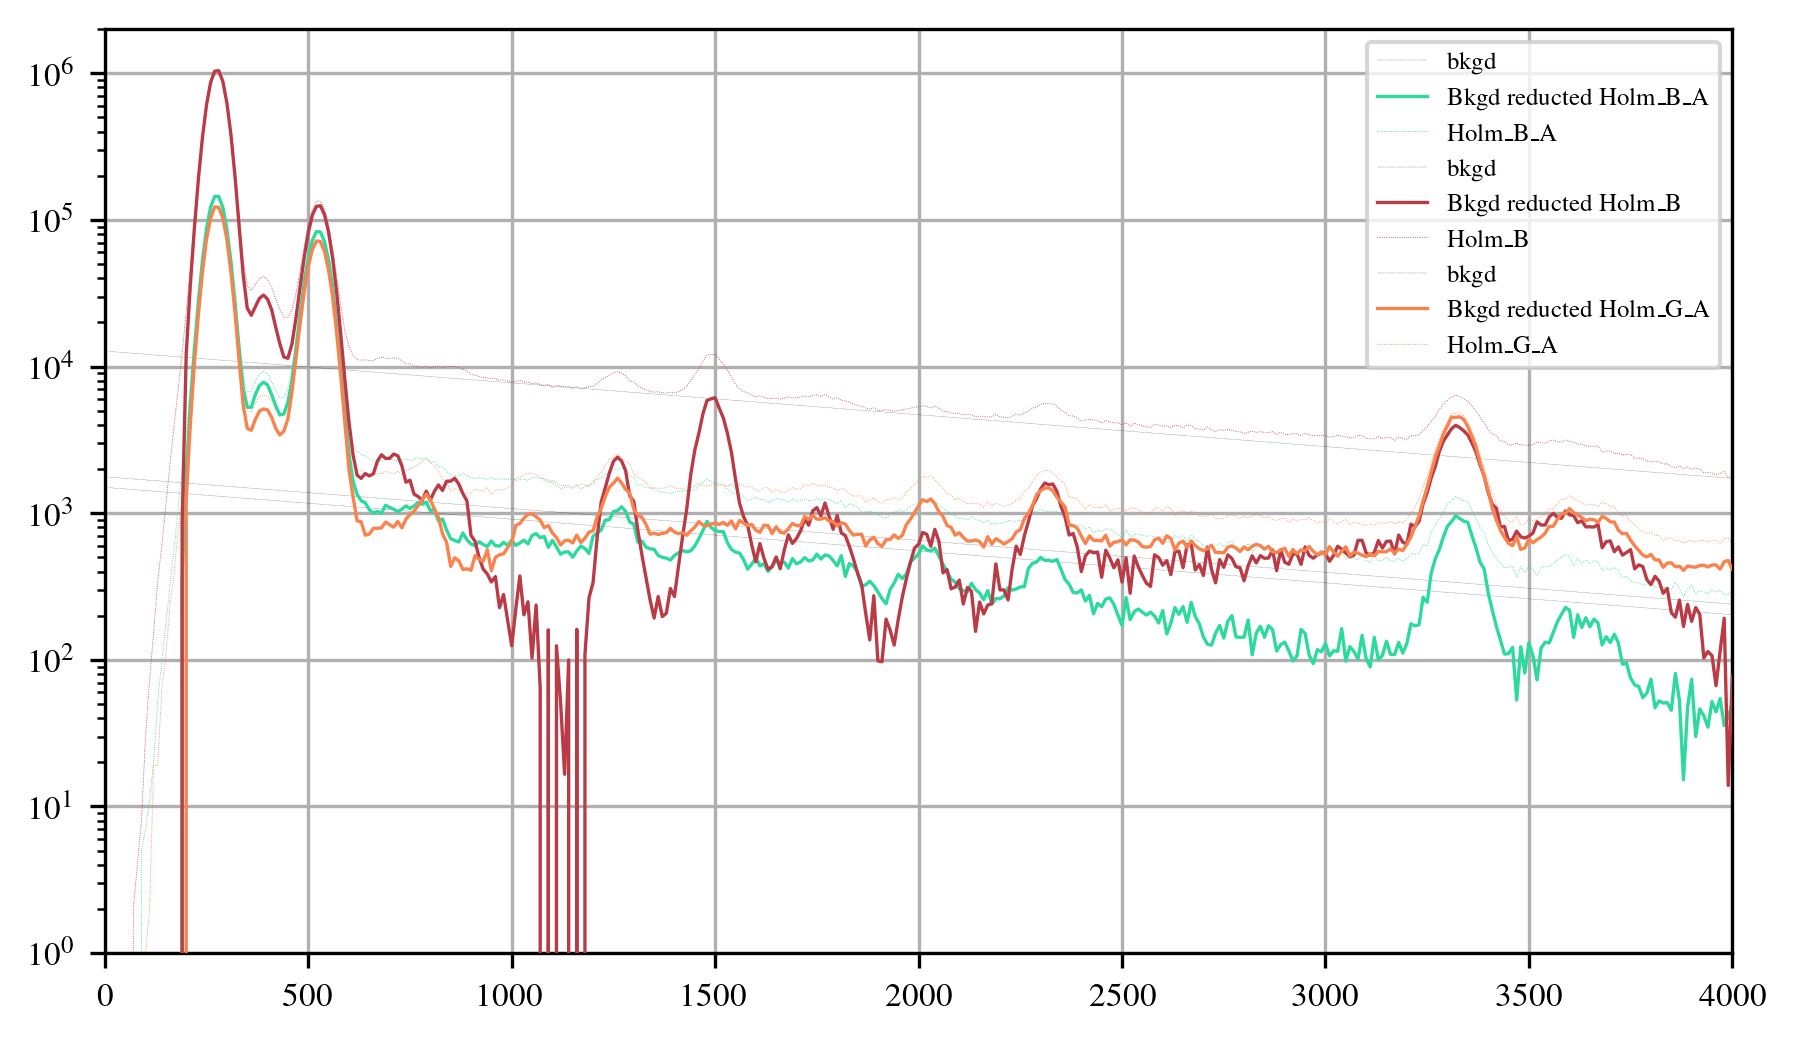

In [195]:
#Coffee Study
files = ['.//Study_2508_Coffee//data//Holm_Kol_Bohne_A.csv',
         './/Study_2508_Coffee/data//Holm_Kol_Bohne.csv',
         './/Study_2508_Coffee//data//Holm_Kol_Gemahlen_A.csv']
dictnames = ['Holm_B_A', 'Holm_B', 'Holm_G_A']

multi_spectra_single_plot(files, dictnames)


In [11]:
# data = json_to_np(json_path + "//BonnPIXE2_Blade15_Front17544_PIXE_1.json" , json_field='all')
# print(np.max(data['Ekin']))


True
[1.01347009 1.02139092 2.08803754 ... 1.02209784 0.03220574 1.28964043]
Data set loaded: 1/5
True
[0.69714417 1.65240517 1.38195523 ... 0.01491866 2.53615635 4.90358492]
Data set loaded: 2/5
True
[3.47517506 1.43580797 0.03181872 ... 1.55662559 2.47362638 0.78874158]
Data set loaded: 3/5
True
[0.89843893 2.26472503 0.90896501 ... 0.76325786 1.98496472 0.48595862]
Data set loaded: 4/5
True
[1.85210569 1.93209616 0.03639189 ... 1.82185848 1.11065658 0.03220568]
Data set loaded: 5/5


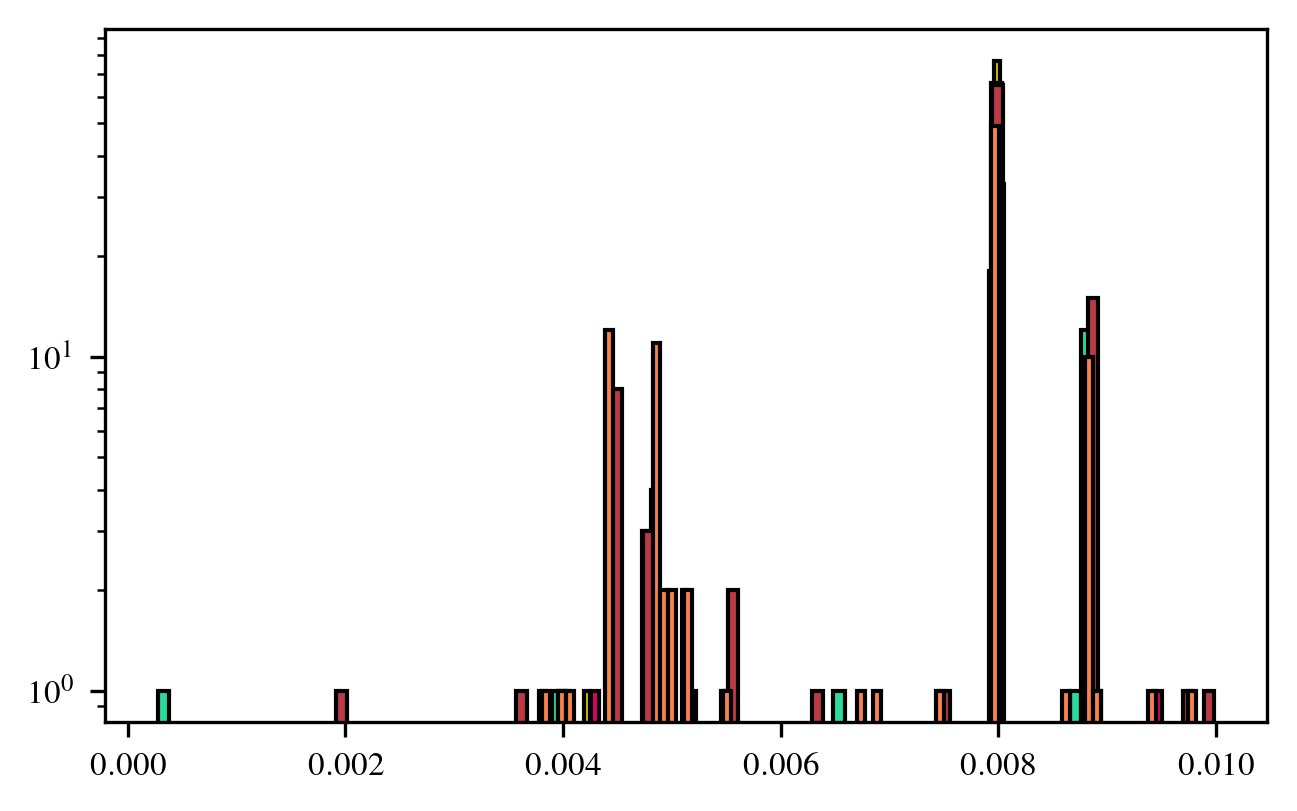

{'//YBCO_10mu_proton_7-0_25044_PIXE_1.jsonbe': array([0.00377832, 0.00384728, 0.00391624, 0.0039852 , 0.00405415,
        0.00412311, 0.00419207, 0.00426103, 0.00432999, 0.00439894,
        0.0044679 , 0.00453686, 0.00460582, 0.00467477, 0.00474373,
        0.00481269, 0.00488165, 0.00495061, 0.00501956, 0.00508852,
        0.00515748, 0.00522644, 0.0052954 , 0.00536435, 0.00543331,
        0.00550227, 0.00557123, 0.00564019, 0.00570914, 0.0057781 ,
        0.00584706, 0.00591602, 0.00598498, 0.00605393, 0.00612289,
        0.00619185, 0.00626081, 0.00632977, 0.00639872, 0.00646768,
        0.00653664, 0.0066056 , 0.00667456, 0.00674351, 0.00681247,
        0.00688143, 0.00695039, 0.00701935, 0.0070883 , 0.00715726,
        0.00722622, 0.00729518, 0.00736414, 0.00743309, 0.00750205,
        0.00757101, 0.00763997, 0.00770893, 0.00777788, 0.00784684,
        0.0079158 , 0.00798476, 0.00805372, 0.00812267, 0.00819163,
        0.00826059, 0.00832955, 0.00839851, 0.00846746, 0.00853642,
  

In [12]:
files = ['//YBCO_10mu_proton_7-0_25044_PIXE_1.json',
         '//YBCO_10mu_proton_8-5_20760_PIXE_1.json',
         '//YBCO_10mu_proton_10-0_9848_PIXE_1.json',
         '//YBCO_10mu_proton_12-0_26620_PIXE_1.json',
         '//YBCO_10mu_proton_14-0_19704_PIXE_1.json']
multi_histo(prm=PARAM_XRAY_L, files=files)
# array_to_histo(PARAM_XRAY_L, data['Ekin'],yscale='log')
# array_to_histo(data['Ekin'], mask_max=520)